<a href="https://colab.research.google.com/github/rballachay/homework/blob/main/COMP551/COMP551_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tarfile
import pandas as pd
import requests
import os
from pathlib import Path

URL = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

# get second dataframe by requests + tar extract
data = requests.get(URL)
with open('cifar-10-python.tar.gz', 'wb') as f:
    f.write(data.content)

# extract tar file to folder with same name
with tarfile.open('cifar-10-python.tar.gz') as f:
    f.extractall('./')

In [ ]:
%pip install ipyplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.9 MB/s eta 0:00:00


In [ ]:
import pickle
import tensorflow as tf
import ipyplot

FOLDER = 'cifar-10-batches-py'
TRAIN_PREFIX='data_batch'
TEST_PREFIX='test_batch'

# get all the data_bath
train_data = list(Path(f'{FOLDER}').glob(f'{TRAIN_PREFIX}*'))
test_data = list(Path(f'{FOLDER}').glob(f'{TEST_PREFIX}*'))

def unpickle(file):
  with open(str(file), 'rb') as fo:
    asdict = pickle.load(fo, encoding='bytes')
  return asdict

train_dicts = list(map(unpickle, train_data))
test_dicts = list(map(unpickle, test_data))

def unpack(imgdict):
  return imgdict[b'labels'], imgdict[b'data']

unpacked_training = list(map(unpack, train_dicts))
unpacked_testing = list(map(unpack, test_dicts))

# convert list of tuples to tuple of lists
train_labels, train_data = list(zip(*unpacked_training))
test_labels, test_data = list(zip(*unpacked_testing))

# labels can be flat array of single dimension
y_train = tf.concat(train_labels,axis=0)
y_test = tf.concat(test_labels,axis=0)

x_train = tf.cast(tf.concat(train_data,axis=0),dtype=float)
x_test = tf.cast(tf.concat(test_data,axis=0),dtype=float)


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `force_b64` param to `True`.
        


testing data shape (50000, 3072)



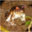
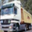
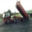
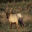
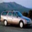
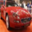
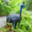
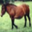
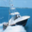
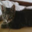
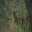
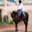
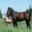
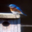
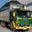
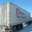
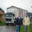
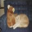
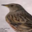
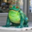
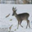
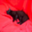
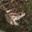
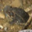
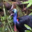
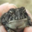
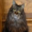
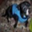
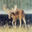
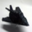
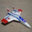
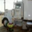
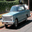
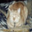
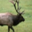
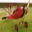
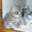
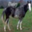
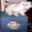
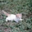
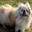
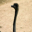
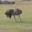
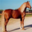
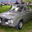
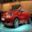
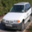
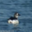
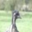
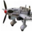
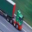
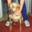
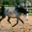
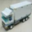
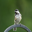
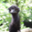
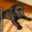
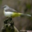
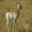
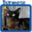
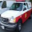
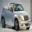
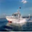
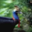
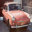
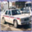
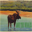
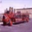
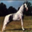
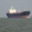
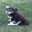
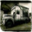
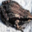
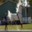
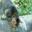
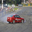
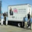
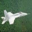
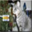
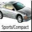
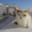
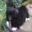
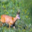
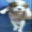
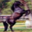
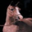
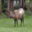
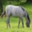
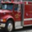
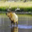
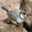
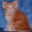
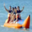
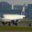
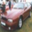
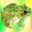
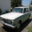
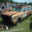
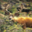
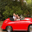


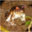
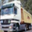
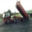
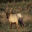
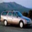
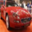
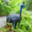
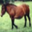
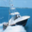
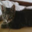
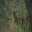
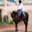
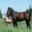
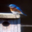
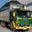
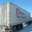
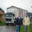
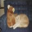
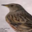
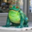
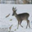
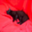
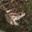
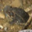
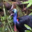
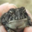
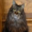
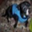
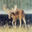
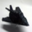
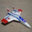
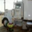
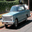
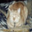
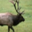
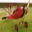
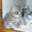
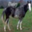
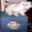
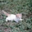
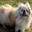
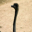
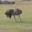
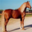
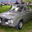
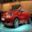
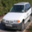
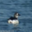
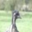
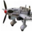
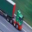
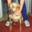
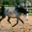
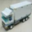
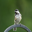
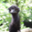
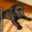
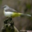
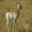
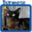
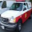
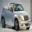
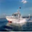
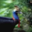
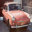
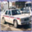
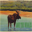
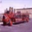
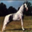
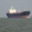
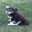
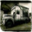
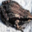
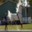
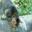
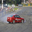
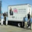
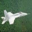
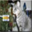
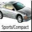
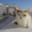
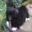
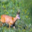
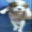
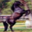
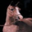
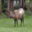
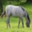
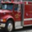
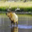
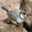
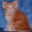
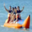
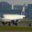
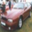
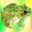
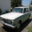
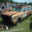
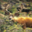
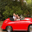

testing data shape (10000, 3072)



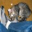
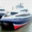
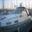
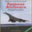
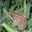
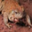
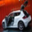
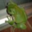
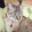
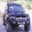
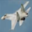
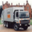
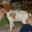
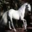
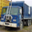
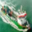
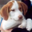
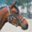
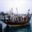
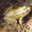
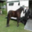
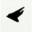
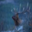
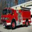
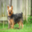
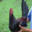
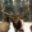
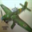
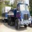
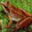
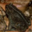
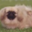
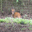
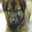
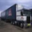
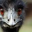
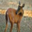
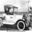
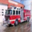
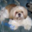
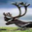
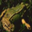
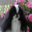
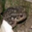
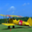
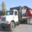
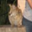
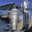
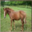
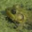
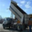
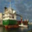
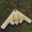
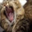
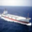
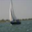
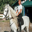
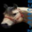
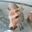
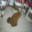
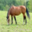
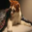
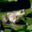
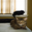
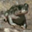
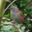
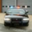
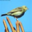
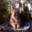
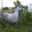
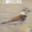
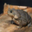
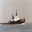
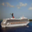
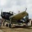
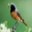
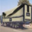
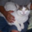
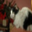
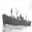
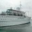
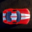
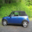
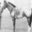
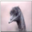
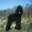
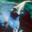
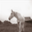
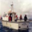
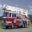
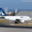
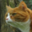
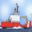
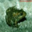
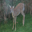
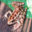
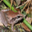
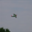
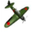
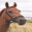


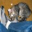
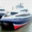
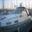
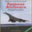
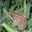
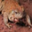
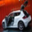
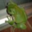
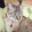
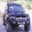
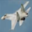
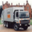
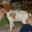
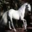
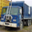
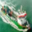
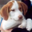
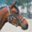
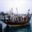
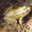
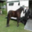
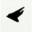
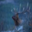
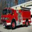
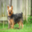
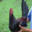
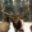
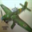
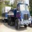
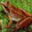
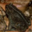
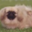
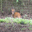
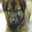
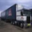
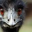
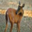
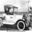
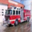
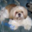
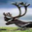
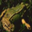
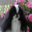
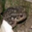
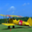
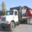
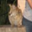
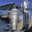
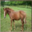
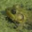
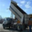
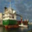
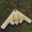
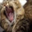
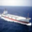
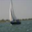
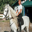
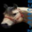
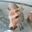
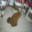
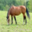
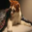
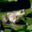
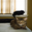
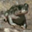
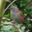
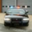
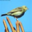
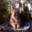
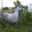
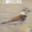
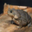
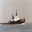
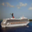
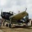
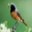
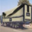
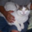
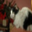
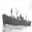
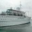
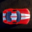
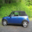
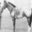
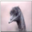
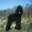
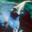
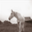
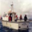
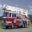
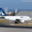
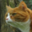
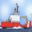
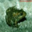
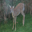
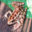
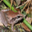
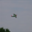
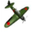
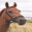

In [ ]:
import numpy as np
########################
## VISUALIZE THE DATA ##
########################

# reshape image data back to real images, 1st dimension is instances
x_images = np.reshape(x_train.numpy(), (x_train.shape[0],32,32,3),order='F')
x_images = np.swapaxes(x_images, 1, 2)

x_testimgs = np.reshape(x_test.numpy(), (x_test.shape[0],32,32,3),order='F')
x_testimgs = np.swapaxes(x_testimgs, 1, 2)

assert x_train.shape[0] == y_train.shape[0]
print('testing data shape', x_train.shape)
ipyplot.plot_images(x_images, max_images=100, img_width=32)

assert x_test.shape[0] == y_test.shape[0]
print('testing data shape', x_test.shape)
ipyplot.plot_images(x_testimgs, max_images=100, img_width=32)

### Activations

In [ ]:
import tensorflow as tf

def relu(z):
    return tf.math.maximum(0, z)

def softmax(z):
    return tf.math.softmax(z)

def leaky_relu(z):
    return tf.math.maximum(0.01*z, z)

def tanh(z):
    return tf.math.tanh(z)

def d_relu(dA, Z):
    return tf.experimental.numpy.where(Z <= 0, 0, dA)

def d_softmax(dA, Z):
    return dA

def d_leaky_relu(dA, Z):
    return tf.experimental.numpy.where(Z <= 0, 0.01*dA, dA)

def d_tanh(dA, Z):
    return dA*(1-tf.math.tanh(Z)**2)

Activations = {
    'relu':{'fx':relu, 'dx':d_relu},
    'softmax':{'fx':softmax, 'dx':d_softmax},
    'leaky_relu':{'fx':leaky_relu, 'dx':d_leaky_relu},
    'tanh':{'fx':tanh, 'dx':d_tanh}

}

### Regularization

In [ ]:
from abc import ABC, abstractmethod

class Regularization(ABC):
    def __init__(self, rate=0):
        self.rate=rate
    @abstractmethod
    def __call__(self, x, y, *args):
        raise NotImplementedError()

class L2(Regularization):
    def __call__(self, z, *args):
        return self.rate*0.5*tf.math.reduce_sum(tf.math.square(z))

class L1(Regularization):
    def __call__(self, z, *args):
        return self.rate*tf.math.reduce_sum(tf.math.abs(z))

class NoReg(Regularization):
    def __call__(self, *args):
        return 0

### Optimizers

In [ ]:
from abc import ABC, abstractmethod

# base class to ensure we have delta method
class Optimizer(ABC):
    @abstractmethod
    def delta(self, **kwargs):
        raise NotImplementedError()

class SGD(Optimizer):
    def __init__(self, learning_rate, **kwargs):
        self.learning_rate = learning_rate
      
    def delta(self, grads, params, **kwargs):
        return self.learning_rate * grads

class Adam(Optimizer):
    def __init__(self, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = []
        self.v = []
        self.t = []

    def delta(self, grads, params, idx):
        if idx+1>len(self.m):
            self.m.append(0)
            self.t.append(0)
            self.v.append(0)

        self.t[idx] = self.t[idx] + 1
        self.m[idx] = self.beta1*self.m[idx] + (1 - self.beta1)*grads
        self.v[idx] = self.beta2*self.v[idx] + (1 - self.beta2)* tf.math.square(grads)
        m_hat = self.m[idx]/(1 - tf.math.pow(self.beta1, self.t[idx]))
        v_hat = self.v[idx]/(1 - tf.math.pow(self.beta2, self.t[idx]))
        return self.learning_rate*(m_hat/(tf.math.sqrt(v_hat) + self.epsilon))



### Model

In [ ]:
import numpy as np
import pandas as pd
from copy import copy, deepcopy

class DenseLayer:
    def __init__(self, neurons, activation):
        self.neurons = neurons
        self.activation = Activations[activation.lower()]['fx']
        self.derivative = Activations[activation.lower()]['dx']
    
    def forward(self, inputs, weights, bias):
        Z_curr = tf.tensordot(inputs, tf.transpose(weights), axes = [[1], [0]]) + bias
        A_curr = self.activation(Z_curr)
        return A_curr, Z_curr
    
    def backward(self, dA_curr, W_curr, Z_curr, A_prev):
        dZ = self.derivative(dA_curr, Z_curr)
        dW = tf.transpose(tf.tensordot(tf.transpose(A_prev), dZ, axes = [[1], [0]]))
        db = tf.math.reduce_sum(dZ, axis=0, keepdims=True)
        dA = tf.tensordot(dZ, W_curr, axes = [[1], [0]])
        return dA, dW, db
            

class MLPMultiClass:
    def __init__(self, layers, activations, epochs=1e5, epsilon=1e-200, \
                 optimizer=SGD(1e-5), batch_size=64, val_frac=0.25, \
                 regularization=NoReg(), store_best=True, patience = 25):
        """for a 3 (2-hidden) layer MLP with four predictors,
        should have (this is an example, can change values):

        layers: [64, 64, 4]
        activations: ['reLU', 'reLU', 'softmax']
        """
        assert len(layers)==len(activations)

        self.network = list(map(DenseLayer, layers, activations))
        self.depth=len(self.network)
        self.architecture = [] ## mapping input neurons --> output neurons
        self.params = [] ## W, b

        self.epochs = epochs
        self.epsilon = epsilon

        # learning rate can either be a constant, or an instance of Adam
        # this needs to be a dictionary because we separate bias and weights
        self.optimizer = {'W':deepcopy(optimizer),'b':deepcopy(optimizer)}
        self.batch_size = batch_size
        self.val_frac = val_frac

        # in this dictionary, x is lambda and y is the parameter dictionary
        # concatted into a single tensor
        self.regularization = regularization

        # store best weights, based on validation set loss
        self.store_best = store_best

        # number of epochs that validation error can increase 
        self.patience = patience
        
    def _compile(self, data):
        for idx in range(self.depth):
            if idx == 0:
                self.architecture.append({'input_dim':data.shape[1], 'output_dim':self.network[idx].neurons})
            else:
                self.architecture.append({'input_dim':self.network[idx-1].neurons, 'output_dim':self.network[idx].neurons})

        return self
    
    def _init_weights(self, data):
        self._compile(data)
        
        for i in range(len(self.architecture)):
            self.params.append({
                'W':tf.random.uniform((self.architecture[i]['output_dim'], 
                        self.architecture[i]['input_dim']),minval=-0.01, maxval=0.01,dtype=tf.float32),
                'b':tf.zeros((1, self.architecture[i]['output_dim']),dtype=tf.float32)})
        
        return self
    
    def predict(self, data, remember=True):
        # whether or not we want to store the memory from this forward prop
        if remember:
            self.memory = []

        A_curr = data
        
        for i in range(len(self.params)):
            A_prev = A_curr
            A_curr, Z_curr = self.network[i].forward(inputs=A_prev, weights=self.params[i]['W'], 
                                           bias=self.params[i]['b'])
            
            if remember: 
                self.memory.append({'inputs':A_prev, 'Z':Z_curr})
            
        return A_curr
    
    def _calculate_loss_grad(self, predicted, actual):
        num_samples = len(actual)

        ## compute the gradient on predictions
        dscores = predicted.numpy()
        dscores[tf.range(len(actual)),actual] -= 1
        dscores /= num_samples
        dA_prev =  tf.convert_to_tensor(dscores)
        return dA_prev

    def _squeeze_weights(self, params):
        """in order to get the weights out of the dictionary, we need to pull
        out all values, flatten and concat
        """
        weights = tf.nest.flatten(params)
        weights = list(map(lambda x: tf.reshape(x,[-1]), weights))
        return tf.concat(weights, axis=0)

    def _backprop(self, predicted, actual):
        self.gradients=[]

        # calculate loss (without regularization)
        dA_prev_unreg =  self._calculate_loss_grad(predicted, actual)

        # flatten weights + add regularization term
        weights_flat = self._squeeze_weights(self.params)
        dA_prev = dA_prev_unreg + self.regularization(weights_flat)


        for idx, layer in reversed(list(enumerate(self.network))):
            dA_curr = dA_prev
            
            A_prev = self.memory[idx]['inputs']
            Z_curr = self.memory[idx]['Z']
            W_curr = self.params[idx]['W']
            
            dA_prev, dW_curr, db_curr = layer.backward(dA_curr, W_curr, Z_curr, A_prev)

            self.gradients.append({'dW':dW_curr, 'db':db_curr})

        # need to reverse gradients here, it is in opposite direction as weights
        self.gradients = list(reversed(self.gradients))
   
    def _update(self):
        for idx, layer in enumerate(self.network):
            grads = self.gradients[idx]
            params = self.params[idx]
            self.params[idx]['W'] -= self.optimizer['W'].delta(grads['dW'], params['W'], idx)
            self.params[idx]['b'] -= self.optimizer['b'].delta(grads['db'], params['b'], idx)
    
    @staticmethod
    def _get_accuracy(predicted, actual):
        prediction = tf.math.argmax(predicted, axis=1)
        equality = tf.math.equal(tf.cast(prediction,float), tf.cast(actual,float))
        accuracy = tf.math.reduce_mean(tf.cast(equality, tf.float32))
        return accuracy

    @staticmethod
    def _calculate_loss(logit, y, reduce_mean=True):
        """the loss here is exslusively used for evaluation, 
        therefore it does not include regularization terms
        """
        cce = \
            -tf.reduce_sum(
                tf.math.log(
                    tf.nn.softmax(logit)
                ) *
                tf.one_hot(
                    tf.cast(y, tf.int32), 
                    logit.shape[1]
                ),
                axis=-1
            )
        if reduce_mean:
            cce = tf.reduce_mean(cce)
        return cce

    def _get_minibatch(self, train_idxs):
        ridxs = tf.random.shuffle(train_idxs)[:self.batch_size]
        return ridxs

    def _get_val_idx(self, X_train):
        shape = int(tf.shape(X_train)[0])
        cut = int(self.val_frac*shape)
        idxs = tf.range(shape)
        shuffled = tf.random.shuffle(idxs)
        val_idxs = shuffled[:cut]
        train_idxs = shuffled[cut:]
        return val_idxs, train_idxs
    
    
    def fit(self, X_train, y_train):
        # we are going to set aside 1/4 of the data for validation,
        # here we get the indices we are using for validation
        val_idxs, train_idxs = self._get_val_idx(X_train)
        X_val = tf.gather(X_train, val_idxs)
        y_val = tf.gather(y_train, val_idxs)

        # init 
        self.loss = []
        self.val_loss = []
        self.accuracy = []
        self.val_accuracy = []
        self._init_weights(X_train)

        # init best weights + loss
        self.best_weights = self.params.copy()
        self.best_loss = np.inf
        norms=np.array([np.inf])
        t=1
        early_stop_epochs=0
        increasing_buffer=0

        # main training loop
        while t < self.epochs and early_stop_epochs<self.patience: # tf.math.reduce_any(norms > self.epsilon) and

            # get the minibatch randomly
            ridxs = self._get_minibatch(train_idxs)
            y_batch = tf.gather(y_train, ridxs)
            X_batch = tf.gather(X_train, ridxs)

            # run and update metrics
            yhat = self.predict(X_batch)
            self.accuracy.append(self._get_accuracy(predicted=yhat, actual=y_batch))
            self.loss.append(self._calculate_loss(logit=yhat, y=y_batch))

            # update accuracy and loss, for train and val set
            yhat_val = self.predict(X_val, remember=False)
            self.val_accuracy.append(self._get_accuracy(predicted=yhat_val, actual=y_val))
            val_loss_i = self._calculate_loss(logit=yhat_val, y=y_val)
            self.val_loss.append(val_loss_i)

            # every 10 iterations, check to see if we have improved on validation loss,
            # and if we have, update best_weights
            if (t % 10 == 0) & (val_loss_i < self.best_loss):
                self.best_weights = self.params.copy() 
                self.best_loss = val_loss_i

            # if the loss is lower at the last step than the current step,
            # our loss is increasing
            if self.val_loss[t-2] < self.val_loss[t-1]:
                early_stop_epochs+=1
            else:
                increasing_buffer+=1

            if increasing_buffer>5:
                early_stop_epochs=0
                increasing_buffer=0

            # update weights
            self._backprop(predicted=yhat, actual=y_batch)
            self._update()
            
            
            if t % 100 == 0:
                s = f'EPOCH: {t:05d}, ACCURACY: {self.accuracy[-1]:.2f}, LOSS: {self.loss[-1]:.2f}, VAL ACCURACY: {self.val_accuracy[-1]:.2f}, VAL LOSS: {self.val_loss[-1]:.2f}'
                print(s)
          
            t+=1
            norms = np.array([tf.norm(g) for g in list(map(lambda x:x['dW'],self.gradients))])


        # after training is done, update weights to be the best weight dictionary
        # possible, so that we aren't punished for training too long and falling
        # out of a local optima
        self.params = self.best_weights

### Experiment Object

In [ ]:
import pandas as pd
from copy import deepcopy 
from sklearn.metrics import accuracy_score, roc_auc_score

class Experiment:
    def __init__(self, models:dict): 
        self.models = models

    @property
    def train_df(self):
        def unpack_models():
          for title,model in self.models.items():
              yield pd.DataFrame({
                  **self.defaults(model),
                  'epoch':list(np.arange(1,len(model.val_accuracy)+1)),
                  'val_accuracy': self.eat(model.val_accuracy),
                  'train_accuracy':self.eat(model.accuracy),
                  'train_loss':self.eat(model.loss),
                  'val_loss':self.eat(model.val_loss)
              })
        return pd.concat(list(unpack_models())).reset_index(drop=True)

    @staticmethod
    def eat(tensor):
        return list(map(lambda x: x.numpy(),tensor))

    def eval(self, x_train, y_train, x_test, y_test):
        def unpack_models():
          for title,model in self.models.items():
              y_hat_test = model.predict(x_test)
              y_hat_train = model.predict(x_train)
              acc_test = accuracy_score(y_test, tf.math.argmax(y_hat_test, axis=1))
              auroc_test = roc_auc_score(y_test, y_hat_test,multi_class='ovr')
              acc_train = accuracy_score(y_train, tf.math.argmax(y_hat_train, axis=1))
              auroc_train = roc_auc_score(y_train, y_hat_train,multi_class='ovr')
              yield pd.DataFrame({
                  **self.defaults(model),
                  'accuracy':[acc_train, acc_test],
                  'auroc':[auroc_train, auroc_test],
                  'stage':['train','test']

              })
        return pd.concat(list(unpack_models())).reset_index(drop=True)

    def eval_list(self, x_train_list, y_train, x_test_list, y_test):
        def unpack_models():
          for (title, model), x_train, x_test, scaling in zip(self.models.items(), x_train_list, x_test_list, ['scaled','unscaled']):
              y_hat_test = model.predict(x_test)
              y_hat_train = model.predict(x_train)
              acc_test = accuracy_score(y_test, tf.math.argmax(y_hat_test, axis=1))
              auroc_test = roc_auc_score(y_test, y_hat_test,multi_class='ovr')
              acc_train = accuracy_score(y_train, tf.math.argmax(y_hat_train, axis=1))
              auroc_train = roc_auc_score(y_train, y_hat_train,multi_class='ovr')
              yield pd.DataFrame({
                  **self.defaults(model),
                  'accuracy':[acc_train, acc_test],
                  'auroc':[auroc_train, auroc_test],
                  'stage':['train','test'],
                  'scaling':scaling

              })
        return pd.concat(list(unpack_models())).reset_index(drop=True)


    @staticmethod
    def defaults(model):
        return {
                'depth':model.depth,
                'activation':model.network[0].activation.__name__,
                'batch_size':model.batch_size,
                'optimizer':model.optimizer['W'].__class__.__name__,
                'learning_rate':model.optimizer['W'].learning_rate,
                'regularization':model.regularization.__class__.__name__,
                'reg_rate': model.regularization.rate if hasattr(model.regularization, 'rate') else None,
        }


def train_models(models_untrained, experiment_title, cache_dir, use_cache, write_cache):
    models = deepcopy(models_untrained)
    for title, model in models.items():
      loaded = False 
      print(f'Starting model {title}: {model}')
      pickled_model = f'{cache_dir}/{experiment_title}_N{title}.pkl'

      if os.path.exists(pickled_model) and use_cache:
          loaded = True
          print('Cache exists! reading cache from drive')
          with open(pickled_model, 'rb') as handle:
              model = pickle.load(handle)
          models[title] = model
      else:
          model.fit(x_train_scaled, y_train)

      if write_cache and not loaded:
          with open(pickled_model, 'wb') as handle:
              pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)   
    return models 

def train_models_xdata(xdata, models_untrained, experiment_title, cache_dir, use_cache, write_cache):
    models = deepcopy(models_untrained)
    for (title, model), _x_train  in zip(models.items(), xdata):
      loaded = False 
      print(f'Starting model {title}: {model}')
      pickled_model = f'{cache_dir}/{experiment_title}_N{title}.pkl'

      if os.path.exists(pickled_model) and use_cache:
          loaded = True
          print('Cache exists! reading cache from drive')
          with open(pickled_model, 'rb') as handle:
              model = pickle.load(handle)
          models[title] = model
      else:
          model.fit(_x_train, y_train)

      if write_cache and not loaded:
          with open(pickled_model, 'wb') as handle:
              pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)   
    return models  

### Data Transformation

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)

# don't want to re-fit here, just transform using the scaler that was fit on train
x_train_scaled = tf.convert_to_tensor(scaler.transform(x_train), dtype=tf.float32)
x_test_scaled = tf.convert_to_tensor(scaler.transform(x_test), dtype=tf.float32)

## Experiment 0, choose hyperparameters

First step is to choose the hyperparameters for each of our models



In [ ]:
from google.colab import drive
import pickle
import tensorflow as tf
import os
drive.mount('/content/drive/')

# set constants
CACHE_DIR = 'drive/MyDrive/COMP551/A2'

# check that cache exists
assert os.path.exists(CACHE_DIR)

# get number of unique classes
UNIQUE_CLASSES = len(set(tf.concat([y_train,y_test],axis=0).numpy()))
print(f'There are {UNIQUE_CLASSES} unique classes')

Mounted at /content/drive/
There are 10 unique classes


<AxesSubplot:xlabel='epoch', ylabel='loss'>

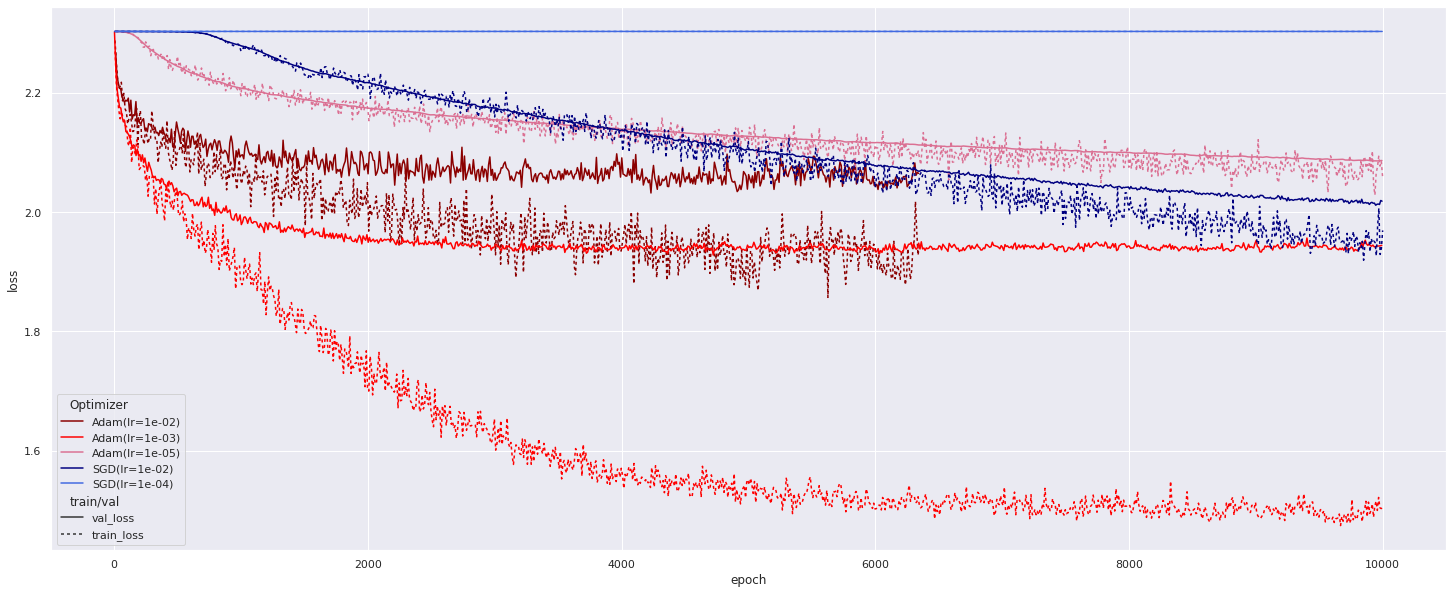

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

USE_CACHE = True
WRITE_CACHE = True
EXPERIMENT_TITLE = 'EXP_1A_HYPERPARAMS'

EPOCHS = 10000
BATCH_SIZE = 256

models_untrained = {
    'lr_2_2layer':MLPMultiClass([256, 256, UNIQUE_CLASSES],['relu','relu','softmax'], epochs=EPOCHS, batch_size=BATCH_SIZE, optimizer=SGD(1e-2)),
    'lr_4_2layer':MLPMultiClass([256, 256, UNIQUE_CLASSES],['relu','relu','softmax'], epochs=EPOCHS, batch_size=BATCH_SIZE, optimizer=SGD(1e-4)),
    'lr_adam_2layer_e5':MLPMultiClass([256, 256, UNIQUE_CLASSES],['relu','relu','softmax'], epochs=EPOCHS, batch_size=BATCH_SIZE, optimizer=Adam(1e-5)),
    'lr_adam_2layer_e4':MLPMultiClass([256, 256, UNIQUE_CLASSES],['relu','relu','softmax'], epochs=EPOCHS, batch_size=BATCH_SIZE, optimizer=Adam(1e-3)),
    'lr_adam_fast_e2':MLPMultiClass([256, 256, UNIQUE_CLASSES],['relu','relu','softmax'], epochs=EPOCHS, batch_size=BATCH_SIZE, optimizer=Adam(1e-2)),
}

# iterate over all the models, load from cache if available
#models = train_models(models_untrained, EXPERIMENT_TITLE, CACHE_DIR, USE_CACHE, WRITE_CACHE)

# plot experiment results
experiment = Experiment(models)
df = experiment.train_df 
df['Optimizer'] = df['optimizer'] + '(lr=' + df['learning_rate'].apply(lambda x: f'{x:.0e}') + ')' 
df=df.sort_values(by=['Optimizer','epoch'])
df = pd.melt(df, id_vars=['Optimizer','epoch'],value_vars=['val_loss','train_loss'],var_name='train/val',value_name='loss')
df = df.iloc[10::10, :]

sns.set_theme()
fig, ax = plt.subplots(1,1, figsize=(25,10))
sns.lineplot(data=df, x='epoch',y='loss', hue='Optimizer',palette=['darkred','red','palevioletred','navy','royalblue'], ax=ax, style='train/val', dashes=["", (2, 2)])

The above experiment compares different optimizers and learning rates for our deepest model, 3-layer. It is assumed this model will always take the longest to train, so any model smaller will need a fewer number of epochs. Clear from the plots is that Adam with a learning rate of 1e-2 is the best optimizer. This will be used for all models moving forward, unless otherwise specified. Early stopping on validation loss with patience of 25 epochs will be used in the case that the number of epochs is too great. We can also see from the plots that the validation accuracy begins to plateau after 5000 epochs, but does not increase

## Experiment 1, Evaluate network depth

<AxesSubplot:xlabel='depth', ylabel='accuracy'>

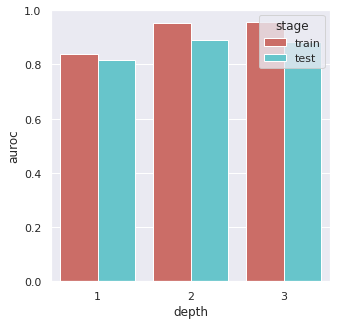

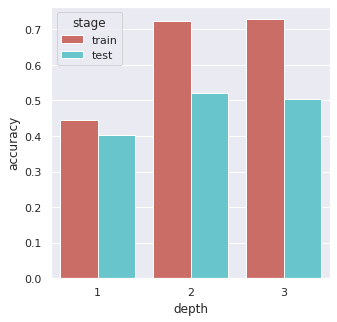

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from  matplotlib.ticker import FuncFormatter

# set constants
USE_CACHE = True
WRITE_CACHE = True
EXPERIMENT_TITLE = 'EXP_1'

EPOCHS = 10000
BATCH_SIZE = 256
OPTIMIZER = Adam(1e-4)

models_untrained={
    1 : MLPMultiClass([UNIQUE_CLASSES],['softmax'], epochs=EPOCHS, batch_size=BATCH_SIZE, optimizer=OPTIMIZER),
    2 : MLPMultiClass([256, UNIQUE_CLASSES],['relu','softmax'], epochs=EPOCHS, batch_size=BATCH_SIZE, optimizer=OPTIMIZER),
    3 : MLPMultiClass([256, 256, UNIQUE_CLASSES],['relu','relu','softmax'], epochs=EPOCHS, batch_size=BATCH_SIZE, optimizer=OPTIMIZER),
}

# iterate over all the models, load from cache if available
models = train_models(models_untrained, EXPERIMENT_TITLE, CACHE_DIR, USE_CACHE, WRITE_CACHE)

exp = Experiment(models)

df = exp.eval(x_train_scaled, y_train, x_test_scaled, y_test)

sns.set_theme()

# plot for AUROC
fig, ax = plt.subplots(1,1, figsize=(5,5))
sns.barplot(data=df, x='depth', y='auroc',hue='stage',palette='hls')

# plot for accuracy
fig, ax = plt.subplots(1,1, figsize=(5,5))
sns.barplot(data=df, x='depth', y='accuracy',hue='stage',palette='hls')

## Experiment 2, Evaluate Activations 

<AxesSubplot:xlabel='activation', ylabel='accuracy'>

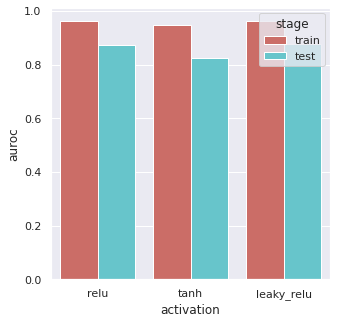

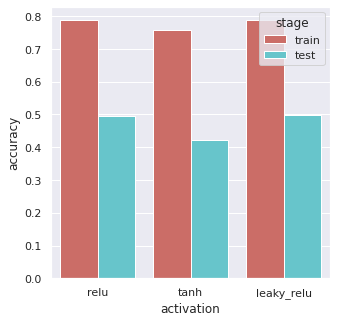

In [ ]:
# set constants
USE_CACHE = True
WRITE_CACHE = True
EXPERIMENT_TITLE = 'EXP_2'

EPOCHS = 10000
BATCH_SIZE = 256
OPTIMIZER = Adam(1e-4)

models_untrained={
    1 : MLPMultiClass([256, 256, UNIQUE_CLASSES],['relu','relu','softmax'], epochs=EPOCHS, batch_size=BATCH_SIZE, optimizer=OPTIMIZER),
    2 : MLPMultiClass([256, 256, UNIQUE_CLASSES],['tanh','tanh','softmax'], epochs=EPOCHS, batch_size=BATCH_SIZE, optimizer=OPTIMIZER),
    3 : MLPMultiClass([256, 256, UNIQUE_CLASSES],['leaky_relu','leaky_relu','softmax'], epochs=EPOCHS, batch_size=BATCH_SIZE, optimizer=OPTIMIZER),
}

# iterate over all the models, load from cache if available
models = train_models(models_untrained, EXPERIMENT_TITLE, CACHE_DIR, USE_CACHE, WRITE_CACHE)

exp = Experiment(models)

df = exp.eval(x_train_scaled, y_train, x_test_scaled, y_test)

# plot for AUROC
fig, ax = plt.subplots(1,1, figsize=(5,5))
sns.barplot(data=df, x='activation', y='auroc',hue='stage',palette='hls')

# plot for accuracy
fig, ax = plt.subplots(1,1, figsize=(5,5))
sns.barplot(data=df, x='activation', y='accuracy',hue='stage',palette='hls')

## Experiment 3, Evaluate Regularization

[None]

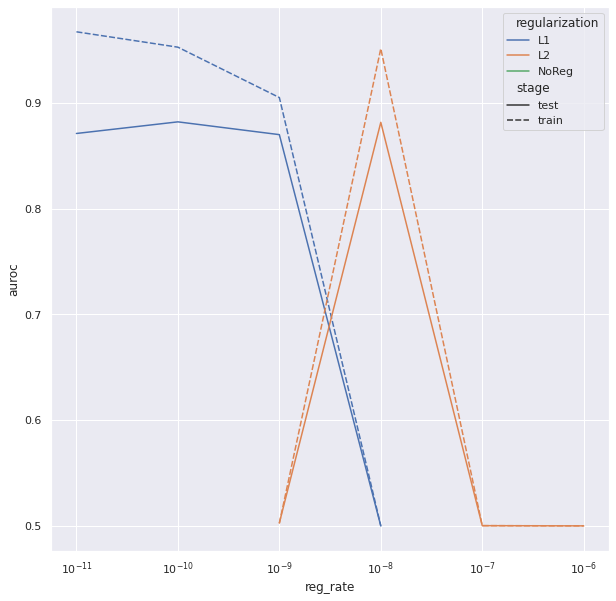

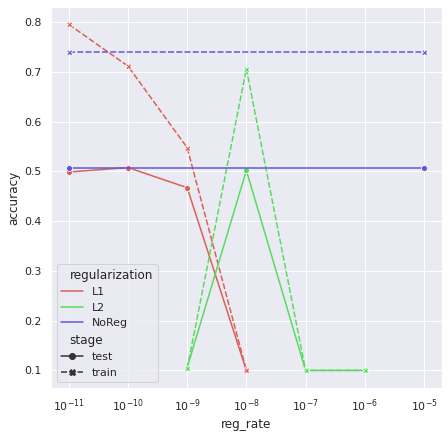

In [ ]:
# set constants
USE_CACHE = True
WRITE_CACHE = True
EXPERIMENT_TITLE = 'EXP_3'

EPOCHS = 10000
BATCH_SIZE = 256
OPTIMIZER = Adam(1e-3)

models_untrained={
    1 : MLPMultiClass([256, 256, UNIQUE_CLASSES],['relu','relu','softmax'], epochs=EPOCHS, batch_size=BATCH_SIZE, optimizer=OPTIMIZER),
    2 : MLPMultiClass([256, 256, UNIQUE_CLASSES],['relu','relu','softmax'], epochs=EPOCHS, batch_size=BATCH_SIZE, optimizer=OPTIMIZER, regularization=L1(1e-8)),
    3 : MLPMultiClass([256, 256, UNIQUE_CLASSES],['relu','relu','softmax'], epochs=EPOCHS, batch_size=BATCH_SIZE, optimizer=OPTIMIZER, regularization=L1(1e-9)),
    4 : MLPMultiClass([256, 256, UNIQUE_CLASSES],['relu','relu','softmax'], epochs=EPOCHS, batch_size=BATCH_SIZE, optimizer=OPTIMIZER, regularization=L1(1e-10)),
    5 : MLPMultiClass([256, 256, UNIQUE_CLASSES],['relu','relu','softmax'], epochs=EPOCHS, batch_size=BATCH_SIZE, optimizer=OPTIMIZER, regularization=L2(1e-8)),
    6 : MLPMultiClass([256, 256, UNIQUE_CLASSES],['relu','relu','softmax'], epochs=EPOCHS, batch_size=BATCH_SIZE, optimizer=OPTIMIZER, regularization=L2(1e-6)),
    7 : MLPMultiClass([256, 256, UNIQUE_CLASSES],['relu','relu','softmax'], epochs=EPOCHS, batch_size=BATCH_SIZE, optimizer=OPTIMIZER, regularization=L2(1e-7)),
    8 : MLPMultiClass([256, 256, UNIQUE_CLASSES],['relu','relu','softmax'], epochs=EPOCHS, batch_size=BATCH_SIZE, optimizer=OPTIMIZER, regularization=L2(1e-9)),
    9 : MLPMultiClass([256, 256, UNIQUE_CLASSES],['relu','relu','softmax'], epochs=EPOCHS, batch_size=BATCH_SIZE, optimizer=OPTIMIZER, regularization=L1(1e-11)),
}

# iterate over all the models, load from cache if available
#models = train_models(models_untrained, EXPERIMENT_TITLE, CACHE_DIR, USE_CACHE, WRITE_CACHE)

exp = Experiment(models)

df = exp.eval(x_train_scaled, y_train, x_test_scaled, y_test)
#df['regularization'] = df['regularization'] + ' (' + df['reg_rate'].apply(lambda x: f'{x:.0e}')  + ')'

df = df.sort_values(by=['regularization','reg_rate','stage'])

# plot for AUROC
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.lineplot(data=df, x='reg_rate', y='auroc',hue='regularization',style='stage')
ax.set(xscale="log")

noreg = df[df['regularization']=='NoReg']['accuracy'].values
# plot for accurac
newdata = {
    'stage':['test']*2 +['train']*2,
    'reg_rate':list(np.logspace(-11,-5,2))*2,
    'accuracy':[noreg[0]]*2 + [noreg[1]]*2,
    'regularization':['NoReg']*4

}
df=df.append(pd.DataFrame(newdata)).reset_index(drop=True)
df = df[df['reg_rate']!=0]

fig, ax = plt.subplots(1,1, figsize=(7,7))
sns.lineplot(data=df, x='reg_rate', y='accuracy',hue='regularization',style='stage', markers=True,palette='hls')
ax.set(xscale="log")

## Experiment 4, Unnormalized Images

<AxesSubplot:xlabel='scaling', ylabel='accuracy'>

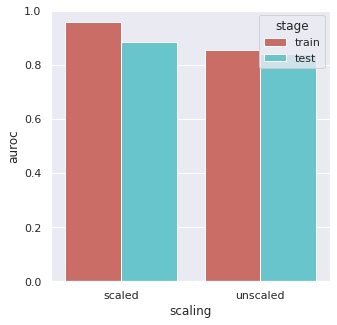

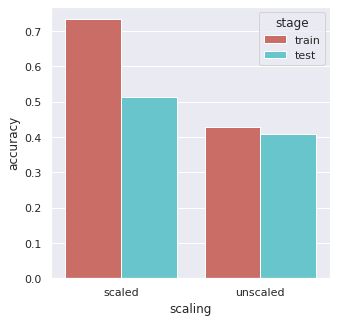

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# set constants
USE_CACHE = True
WRITE_CACHE = True
EXPERIMENT_TITLE = 'EXP_4'

EPOCHS = 10000
BATCH_SIZE = 256
OPTIMIZER = Adam(1e-4)

models_untrained={
    1 : MLPMultiClass([256, 256, UNIQUE_CLASSES],['relu','relu','softmax'], epochs=EPOCHS, batch_size=BATCH_SIZE, optimizer=OPTIMIZER),
    2 : MLPMultiClass([256, 256, UNIQUE_CLASSES],['relu','relu','softmax'], epochs=EPOCHS, batch_size=BATCH_SIZE, optimizer=OPTIMIZER),
}

# iterate over all the models, load from cache if available
#models = train_models_xdata([x_train_scaled, x_train], models_untrained, EXPERIMENT_TITLE, CACHE_DIR, USE_CACHE, WRITE_CACHE)

exp = Experiment(models)

df = exp.eval_list([x_train_scaled,x_train], y_train, [x_test_scaled,x_test], y_test)

# plot for AUROC
fig, ax = plt.subplots(1,1, figsize=(5,5))
sns.barplot(data=df, x='scaling', y='auroc',hue='stage',palette='hls')

# plot for accuracy
fig, ax = plt.subplots(1,1, figsize=(5,5))
sns.barplot(data=df, x='scaling', y='accuracy',hue='stage',palette='hls')

## Experiment 5, CNN 

27


<AxesSubplot:xlabel='num_convs', ylabel='test_acc'>

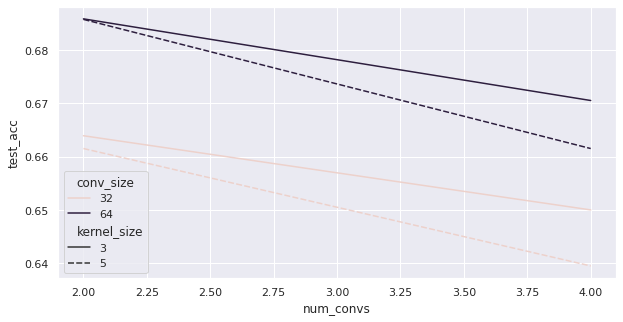

In [ ]:
import tensorflow as tf
import keras
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.models import Sequential 
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import numpy as np
from itertools import product
from sklearn.metrics import accuracy_score
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

class CNNModel():
    def __init__(self, conv_layer, dense_layer, kernel_size=5, activation='relu', \
                 input_shape=(32,32,3), n_classes=10, epochs=100, \
                 val_frac=0.25, batch_size = 256):
        self.model = Sequential()
        for layer in conv_layer:
            self.model.add(Conv2D(layer, kernel_size=kernel_size, \
                                  activation=activation, kernel_initializer='he_uniform', \
                                  padding='same'))
            self.model.add(MaxPooling2D((2, 2)))
        self.model.add(Flatten())
        for layer in dense_layer:
            self.model.add(Dense(layer, activation=activation))
        self.model.add(Dense(n_classes, activation='softmax'))
        self.model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy',metrics=['accuracy'])
        self.epochs = epochs
        self.val_frac = val_frac
        self.batch_size = batch_size

        # add early stopping 
        self.early_stopping = EarlyStopping(monitor='val_loss',patience=10)

    def train(self, x_train, y_train):

        # re-shape data into appropriate size for training 
        x_train = self.squeeze(x_train)
        y_train = tf.one_hot(y_train, 10)

        # fit model
        self.model.fit(x_train, y_train, validation_split=0.25, \
                       epochs=self.epochs, batch_size=self.batch_size,
                       callbacks=[self.early_stopping])
    
    def squeeze(self, x_arr):
        _x_arr = np.reshape(x_arr.numpy(), (x_arr.shape[0],32,32,3),order='F')
        _x_arr = np.swapaxes(_x_arr, 1, 2)
        return _x_arr
    
    def predict(self, x_test):
        x_test = self.squeeze(x_test)
        results = self.model.predict(x_test)
        return np.argmax(results,axis=1)

class Experiment():
    def __init__(self, kernel_sizes, conv_sizes, num_convs):
        self.kernel_sizes = kernel_sizes 
        self.conv_sizes = conv_sizes
        self.num_conv = num_convs

        self.results = []
      
    def run(self, x_train, y_train, x_test, y_test):
        iterpool = product(self.kernel_sizes, self.conv_sizes, self.num_conv)
        for kernel_size, conv_size, num_convs in iterpool:
            model = CNNModel([conv_size]*num_convs, [256, 256], kernel_size)
            model.train(x_train, y_train)
            predictions_test = model.predict(x_test)
            predictions_train = model.predict(x_train)

            accuracy_test = accuracy_score(y_test, predictions_test)
            accuracy_train = accuracy_score(y_train, predictions_train)

            self.results.append({
                'kernel_size':kernel_size,
                'conv_size':conv_size,
                'num_convs':num_convs,
                'test_acc':accuracy_test,
                'train_acc':accuracy_train
                }
            )

exp = Experiment([3,5],[32,64],[2,4])
exp.run(x_train_scaled, y_train, x_test_scaled, y_test)
df = pd.DataFrame(exp.results)
sns.set_theme()
plt.figure(figsize=(10,5))
sns.lineplot(data=df, x='num_convs', hue='conv_size', y='test_acc',style='kernel_size')

## Exp 6, Pre-trained CNN

### Model 1, MobileNetv2 trained on ImageNet

In [ ]:
import tensorflow as tf 
from keras.applications import MobileNet
from keras.layers import MaxPooling2D, Flatten, Dense, \
        GlobalAveragePooling2D, Input, UpSampling2D, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import Sequential 
import numpy as np

class ResNet50CIFAR():
    def __init__(self, batch_size = 128, epochs=1000, \
                 allow_update=False):
        self.batch_size=batch_size 
        self.early_stopping = EarlyStopping(monitor='val_loss',patience=3)
        self.epochs=epochs
        self.allow_update = allow_update

    def build_model(self):
        model=Sequential()
        upsample = UpSampling2D((7, 7))
        model.add(upsample)
        backbone =  MobileNet(input_shape=(224,224,3),include_top=False,weights='imagenet')

        # if we don't allow update, update to false
        if not self.allow_update:
            for layer in backbone.layers:
                layer.trainable =  False

        # add the backbone to the model
        model.add(backbone)
        model.add(Dropout(0.3))
        model.add(Flatten())
        model.add(Dense(512,activation=('relu'))) 
        model.add(Dense(256,activation=('relu'))) 
        model.add(Dropout(.3))
        model.add(Dense(128,activation=('relu')))
        model.add(Dropout(.2))
        model.add(Dense(10,activation=('softmax')))
        return model

    def squeeze(self, x_arr):
        _x_arr = np.reshape(x_arr.numpy(), (x_arr.shape[0],32,32,3),order='F')
        _x_arr = np.swapaxes(_x_arr, 1, 2)
        return tf.convert_to_tensor(_x_arr)

    def train(self, x_train, y_train):
        # build model
        model = self.build_model()
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

        # re-shape data into appropriate size for training 
        x_train = self.squeeze(x_train)
        y_train = tf.one_hot(y_train, 10)

        # fit model
        history = model.fit(x_train, y_train, validation_split=0.25, \
                       epochs=self.epochs, batch_size=self.batch_size,
                       callbacks=[self.early_stopping])
        return history, model

    


test accuracy: 0.829
train accuracy: 0.93692


<AxesSubplot:xlabel='epochs', ylabel='accuracy'>

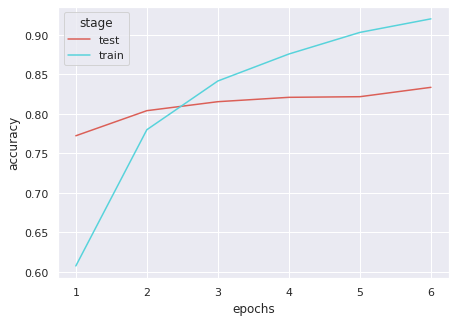

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score 
# first experiment, train and don't allow update in backbone
netwrap = ResNet50CIFAR()
history, model = netwrap.train(x_train_scaled, y_train)

predictions = model.predict(netwrap.squeeze(x_test_scaled))
predictions_train = model.predict(netwrap.squeeze(x_train_scaled))

print('test accuracy:', accuracy_score(y_test, tf.math.argmax(predictions,axis=1)))
print('train accuracy:', accuracy_score(y_train, tf.math.argmax(predictions_train,axis=1)))

df = pd.DataFrame(
    {
        'accuracy':list(history.history['val_accuracy'])+list(history.history['accuracy']),
        'epochs':list(range(1,len(history.history['accuracy'])+1))*2,
        'stage':['test']*6 + ['train']*6

    }
)

plt.figure(figsize=(7,5))
sns.lineplot(data=df,x='epochs',y='accuracy',hue='stage',palette='hls')

Epoch 1/1000
293/293 [==============================] - 211s 653ms/step - loss: 1.0608 - accuracy: 0.7030 - val_loss: 1.0997 - val_accuracy: 0.6969
Epoch 2/1000
293/293 [==============================] - 190s 649ms/step - loss: 0.4289 - accuracy: 0.8706 - val_loss: 0.7911 - val_accuracy: 0.7666
Epoch 3/1000
293/293 [==============================] - 190s 649ms/step - loss: 0.3097 - accuracy: 0.9037 - val_loss: 0.7376 - val_accuracy: 0.7936
Epoch 4/1000
293/293 [==============================] - 190s 649ms/step - loss: 0.2344 - accuracy: 0.9279 - val_loss: 0.4079 - val_accuracy: 0.8625
Epoch 5/1000
293/293 [==============================] - 190s 649ms/step - loss: 0.2043 - accuracy: 0.9374 - val_loss: 0.7409 - val_accuracy: 0.8101
Epoch 6/1000
293/293 [==============================] - 190s 649ms/step - loss: 0.1726 - accuracy: 0.9472 - val_loss: 0.4346 - val_accuracy: 0.8742
Epoch 7/1000
293/293 [==============================] - 191s 651ms/step - loss: 0.1509 - accuracy: 0.9545 - val_

<AxesSubplot:xlabel='epochs', ylabel='accuracy'>

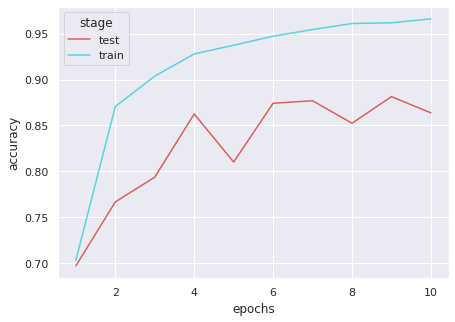

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score 

# first experiment, train and allow update in backbone
netwrap = ResNet50CIFAR(allow_update=True)
history, model = netwrap.train(x_train_scaled, y_train)

predictions = model.predict(netwrap.squeeze(x_test_scaled))
predictions_train = model.predict(netwrap.squeeze(x_train_scaled))

print('test accuracy:', accuracy_score(y_test, tf.math.argmax(predictions,axis=1)))
print('train accuracy:', accuracy_score(y_train, tf.math.argmax(predictions_train,axis=1)))

df = pd.DataFrame(
    {
        'accuracy':list(history.history['val_accuracy'])+list(history.history['accuracy']),
        'epochs':list(range(1,len(history.history['accuracy'])+1))*2,
        'stage':['test']*len(history.history['accuracy']) + ['train']*len(history.history['accuracy'])

    }
)

plt.figure(figsize=(7,5))
sns.lineplot(data=df,x='epochs',y='accuracy',hue='stage',palette='hls')